In [1]:
import numpy as np
import awkward0 as ak

/home/jstrube/.local/lib/python3.8/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


In [2]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

In [3]:
def stack_arrays(a, keys, axis=-1):
    flat_arr = np.stack([a[k].flatten() for k in keys], axis=axis)
    return ak.JaggedArray.fromcounts(a[keys[0]].counts, flat_arr)

In [4]:
def pad_array(a, maxlen, value=0., dtype='float32'):
    x = (np.ones((len(a), maxlen)) * value).astype(dtype)
    for idx, s in enumerate(a):
        if not len(s):
            continue
        trunc = s[:maxlen].astype(dtype)
        x[idx, :len(trunc)] = trunc
    return x

In [5]:
class Dataset(object):

    def __init__(self, filepath, feature_dict = {}, label='label', pad_len=100, data_format='channel_first'):
        self.filepath = filepath
        self.feature_dict = feature_dict
        if len(feature_dict)==0:
            feature_dict['points'] = ['part_etarel', 'part_phirel']
            feature_dict['features'] = ['part_pt_log', 'part_e_log', 'part_etarel', 'part_phirel']
            feature_dict['mask'] = ['part_pt_log']
        self.label = label
        self.pad_len = pad_len
        assert data_format in ('channel_first', 'channel_last')
        self.stack_axis = 1 if data_format=='channel_first' else -1
        self._values = {}
        self._label = None
        self._load()

    def _load(self):
        logging.info('Start loading file %s' % self.filepath)
        counts = None
        with ak.load(self.filepath) as a:
            self._label = a[self.label]
            for k in self.feature_dict:
                cols = self.feature_dict[k]
                if not isinstance(cols, (list, tuple)):
                    cols = [cols]
                arrs = []
                for col in cols:
                    if counts is None:
                        counts = a[col].counts
                    else:
                        assert np.array_equal(counts, a[col].counts)
                    arrs.append(pad_array(a[col], self.pad_len))
                self._values[k] = np.stack(arrs, axis=self.stack_axis)
        logging.info('Finished loading file %s' % self.filepath)


    def __len__(self):
        return len(self._label)

    def __getitem__(self, key):
        if key==self.label:
            return self._label
        else:
            return self._values[key]
    
    @property
    def X(self):
        return self._values
    
    @property
    def y(self):
        return self._label

    def shuffle(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        shuffle_indices = np.arange(self.__len__())
        np.random.shuffle(shuffle_indices)
        for k in self._values:
            self._values[k] = self._values[k][shuffle_indices]
        self._label = self._label[shuffle_indices]

In [6]:
train_dataset = Dataset('converted/train_file_0.awkd', data_format='channel_last')
val_dataset = Dataset('converted/val_file_0.awkd', data_format='channel_last')

[2021-02-05 20:23:20,854] INFO: Start loading file converted/train_file_0.awkd
[2021-02-05 20:23:45,899] INFO: Finished loading file converted/train_file_0.awkd
[2021-02-05 20:23:45,901] INFO: Start loading file converted/val_file_0.awkd
[2021-02-05 20:23:54,502] INFO: Finished loading file converted/val_file_0.awkd


In [7]:
num_classes = train_dataset.y.shape[1]
input_shapes = {k:train_dataset[k].shape[1:] for k in train_dataset.X}

print(num_classes)
print(input_shapes)
print(train_dataset["points"].shape)

2
{'points': (100, 2), 'features': (100, 4), 'mask': (100, 1)}
(1211000, 100, 2)


In [8]:
import matplotlib.pyplot as plt

[2021-02-05 20:23:54,631] INFO: Generating new fontManager, this may take some time...
[2021-02-05 20:23:55,506] INFO: Failed to extract font properties from /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf: In FT2Font: Can not load face.  Unknown file format.


(array([4.92000e+02, 5.08700e+03, 2.70670e+04, 1.02327e+05, 3.70317e+05,
        5.71337e+05, 1.03778e+05, 2.59280e+04, 4.38400e+03, 2.83000e+02]),
 array([-0.8135103 , -0.65463793, -0.49576563, -0.33689326, -0.17802092,
        -0.01914859,  0.13972375,  0.29859608,  0.45746845,  0.61634076,
         0.7752131 ], dtype=float32),
 <BarContainer object of 10 artists>)

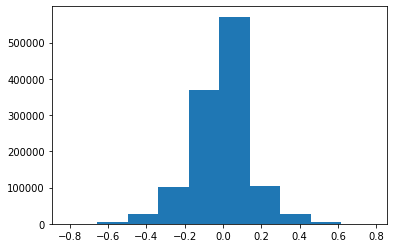

In [9]:
plt.hist(train_dataset["points"][:, 2, 0])

In [10]:
import tensorflow as tf
from tensorflow import keras
from tf_keras_model import get_particle_net, get_particle_net_lite

In [11]:
model_type = 'particle_net_lite' # choose between 'particle_net' and 'particle_net_lite'
num_classes = train_dataset.y.shape[1]
input_shapes = {k:train_dataset[k].shape[1:] for k in train_dataset.X}
if 'lite' in model_type:
    model = get_particle_net_lite(num_classes, input_shapes)
else:
    model = get_particle_net(num_classes, input_shapes)

In [12]:
# Training parameters
batch_size = 1024 if 'lite' in model_type else 384
epochs = 30

In [13]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    logging.info('Learning rate: %f'%lr)
    return lr

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

[2021-02-05 20:23:57,921] INFO: Learning rate: 0.001000


Model: "ParticleNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mask (InputLayer)               [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
tf.math.not_equal (TFOpLambda)  (None, 100, 1)       0           mask[0][0]                       
__________________________________________________________________________________________________
tf.cast (TFOpLambda)            (None, 100, 1)       0           tf.math.not_equal[0][0]          
__________________________________________________________________________________________________
tf.math.equal (TFOpLambda)      (None, 100, 1)       0           tf.cast[0][0]                    
________________________________________________________________________________________

In [12]:
# Prepare model model saving directory.
import os
save_dir = 'model_checkpoints'
model_name = '%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=False)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, lr_scheduler, progress_bar]

In [15]:
train_dataset.shuffle()
model.fit(train_dataset.X, train_dataset.y,
          batch_size=batch_size,
#           epochs=epochs,
          epochs=2, # --- train only for 1 epoch here for demonstration ---
          validation_data=(val_dataset.X, val_dataset.y),
          shuffle=True,
          callbacks=callbacks)

[2020-12-31 18:48:35,890] INFO: Learning rate: 0.001000


Epoch 1/2
      0/Unknown - 2528s 0s/sample - loss: 0.2830 - accuracy: 0.8841
Epoch 00001: saving model to model_checkpoints/particle_net_lite_model.001.h5
1183/1183 [==============================] - 2682s 2s/sample - loss: 0.2528 - accuracy: 0.8970 - val_loss: 0.1916 - val_accuracy: 0.9224


[2020-12-31 19:33:17,877] INFO: Learning rate: 0.001000


Epoch 2/2
   0/1183 [..............................] - ETA: 0s - loss: 0.1856 - accuracy: 0.9249

KeyboardInterrupt: 

In [14]:
train_dataset.X["points"].shape

(1211000, 100, 2)

In [22]:
train_dataset.X["features"].shape

(1211000, 100, 4)